# Music genre classification notebook

## Importing Libraries

In [ ]:
# feature extracting and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import tensorflow
import keras
import pickle
import warnings
warnings.filterwarnings('ignore')

## Extracting music and features

### Dataset

We use [GTZAN genre collection](http://marsyasweb.appspot.com/download/data_sets/) and Indian Music Genre dataset for classification. 
<br>
<br>
The GTZAN dataset consists of 10 genres i.e
 * Blues
 * Classical
 * Country
 * Disco
 * Hiphop
 * Jazz
 * Metal
 * Pop
 * Reggae
 * Rock

And the Indian Music Genre dataset consists of 5 genres i.e.
 * Bollypop
 * Ghazal
 * Sufi
 * Semiclassical
 * Carnatic

Each genre contains 100 songs. Total dataset: 1500 songs

## Extracting the Spectrogram for every Audio

In [ ]:
cmap = plt.get_cmap('inferno')

plt.figure(figsize=(10,10))
genres = 'blues bollypop carnatic classical country disco ghazal hiphop jazz metal pop reggae rock semiclassical sufi'.split()
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()
 


KeyboardInterrupt



Error in callback <function flush_figures at 0x0000014B7300E310> (for post_execute):


All the audio files get converted into their respective spectrograms. We can now easily extract features from them.

## Extracting features from Spectrogram


We will extract

* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Spectral Bandwidth,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [ ]:
header = 'filename tempo chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

## Writing data to csv file

We write the data to a csv file 

In [ ]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues bollypop carnatic classical country disco ghazal hiphop jazz metal pop reggae rock semiclassical sufi'.split()
for g in genres:
    for filename in os.listdir(f'./genres/{g}'):
        songname = f'./genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        beat_times = librosa.frames_to_time(beat_frames, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        rmse = np.sqrt(librosa.feature.rms(y=y))
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(beat_times)} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

The data has been extracted into a data.csv file.

# Analysing the Data in Pandas

In [ ]:
data = pd.read_csv('data.csv')
data.head()

filename       tempo  chroma_stft      rmse  spectral_centroid  \
0  blues.00000.wav  123.046875     0.349943  0.353032        1784.420446   
1  blues.00001.wav   67.999589     0.340983  0.297381        1529.835316   
2  blues.00002.wav  161.499023     0.363603  0.414141        1552.481958   
3  blues.00003.wav   63.024009     0.404779  0.358998        1070.119953   
4  blues.00004.wav  135.999178     0.308590  0.291960        1835.494603   

   spectral_bandwidth      rolloff  zero_crossing_rate       mfcc1  \
0         2002.650192  3806.485316            0.083066 -113.596748   
1         2038.617579  3548.820207            0.056044 -207.556793   
2         1747.165985  3040.514948            0.076301  -90.754387   
3         1596.333948  2185.028454            0.033309 -199.431152   
4         1748.362448  3580.945013            0.101500 -160.266037   

        mfcc2  ...    mfcc12    mfcc13    mfcc14    mfcc15    mfcc16  \
0  121.557297  ...  8.810669 -3.667368  5.751691 -5.162763  0.750948   
1  124.006721  ...  5.376803 -2.239120  4.216963 -6.012273  0.936109   
2  140.459900  ...  5.789265 -8.905224 -1.083720 -9.218359  2.455806   
3  150.099213  ...  6.087676 -2.476421 -1.073890 -2.874778  0.780977   
4  126.198807  ... -2.806383 -6.934123 -7.558618 -9.173553 -4.512165   

     mfcc17    mfcc18    mfcc19     mfcc20  label  
0 -1.691938 -0.409953 -2.300209   1.219929  blues  
1 -0.716537  0.293876 -0.287431   0.531573  blues  
2 -7.726901 -1.815723 -3.433434  -2.226821  blues  
3 -3.316932  0.637982 -0.619690  -3.408233  blues  
4 -5.453538 -0.924161 -4.409333 -11.703781  blues  

[5 rows x 29 columns]

In [ ]:
data.shape

(1499, 29)

In [ ]:
# Dropping unnecessary columns
data = data.drop(['filename'],axis=1)

## Encoding the Labels

In [ ]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

## Scaling the Feature columns

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [ ]:
lookup_genre_name = {0:'blues',1:'bollypop',2:'carnatic',3:'classical',4:'country',
                     5:'disco',6:'ghazal',7:'hiphop',8:'jazz',9:'metal', 10:'pop',
                     11:'reggae',12:'rock',13:'semiclassical',14:'sufi'}   
lookup_genre_name

{0: 'blues',
 1: 'bollypop',
 2: 'carnatic',
 3: 'classical',
 4: 'country',
 5: 'disco',
 6: 'ghazal',
 7: 'hiphop',
 8: 'jazz',
 9: 'metal',
 10: 'pop',
 11: 'reggae',
 12: 'rock',
 13: 'semiclassical',
 14: 'sufi'}

## Dividing data into training and Testing set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(y_train)

1199

In [ ]:
len(y_test)

300

In [ ]:
X_train[10]

array([-1.08134942, -0.53123043, -0.16638579, -1.43135806, -1.38542051,
       -1.54129445, -1.14436556, -0.33254268,  1.96278703, -0.41909478,
       -0.14020169,  0.78185361, -1.70076751,  0.00802416, -0.788509  ,
       -0.09689792, -1.24068266,  1.08945061, -1.23546563, -0.16917704,
        0.363867  , -0.16040787, -0.96964014, -0.20422944, -0.78361242,
        0.60818569, -0.26177049])

# Classification with Keras

## Building our Network

In [ ]:
from keras import models
from keras import layers

model = models.Sequential([
layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
layers.Dropout(0.2),
layers.Dense(128, activation='relu'),
layers.Dropout(0.2),
layers.Dense(64, activation='relu'),
layers.Dropout(0.2),
layers.Dense(15, activation='softmax'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               7168      
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 15)               

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)
                   

Epoch 1/100
10/10 [==============================] - 1s 7ms/step - loss: 2.6250 - accuracy: 0.1251
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 2.3379 - accuracy: 0.3128
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 2.0894 - accuracy: 0.3461
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 1.8625 - accuracy: 0.4053
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 1.6820 - accuracy: 0.4520
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 1.5346 - accuracy: 0.4771
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 1.4329 - accuracy: 0.5104
Epoch 8/100
10/10 [==============================] - 0s 7ms/step - loss: 1.3364 - accuracy: 0.5555
Epoch 9/100
10/10 [==============================] - 0s 7ms/step - loss: 1.3030 - accuracy: 0.5471
Epoch 10/100
10/10 [==============================] - 0s 7ms/step - loss: 1.2464 - accuracy: 0.5822
Epoch 11/

In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test)

10/10 [==============================] - 0s 4ms/step - loss: 1.0606 - accuracy: 0.6733


In [ ]:
print('Test loss: ',test_loss)
print('Test accuracy: ',test_acc)

Test loss:  1.0605602264404297
Test accuracy:  0.6733333468437195


## Validating our approach
Let's set apart 300 samples in our training data to use as a validation set:

In [ ]:
x_val = X_train[:300]
partial_x_train = X_train[300:]

y_val = y_train[:300]
partial_y_train = y_train[300:]

Now let's train our network for 80 epochs:

In [ ]:
model = models.Sequential([
layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
layers.Dropout(0.2),
layers.Dense(256, activation='relu'),
layers.Dropout(0.2),
layers.Dense(128, activation='relu'),
layers.Dropout(0.2),
layers.Dense(64, activation='relu'),
layers.Dropout(0.2),
layers.Dense(15, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

trains = model.fit(partial_x_train,
          partial_y_train,
          epochs=125,
          batch_size=128,
          validation_data=(x_val, y_val),
          shuffle = True,
         )
results = model.evaluate(X_test, y_test)

Epoch 1/125
8/8 [==============================] - 2s 64ms/step - loss: 2.6502 - accuracy: 0.1135 - val_loss: 2.4339 - val_accuracy: 0.3133
Epoch 2/125
8/8 [==============================] - 0s 26ms/step - loss: 2.4063 - accuracy: 0.2147 - val_loss: 2.1340 - val_accuracy: 0.3667
Epoch 3/125
8/8 [==============================] - 0s 26ms/step - loss: 2.1901 - accuracy: 0.3103 - val_loss: 1.8861 - val_accuracy: 0.4167
Epoch 4/125
8/8 [==============================] - 0s 25ms/step - loss: 1.9734 - accuracy: 0.3248 - val_loss: 1.7403 - val_accuracy: 0.4333
Epoch 5/125
8/8 [==============================] - 0s 27ms/step - loss: 1.8302 - accuracy: 0.3815 - val_loss: 1.5965 - val_accuracy: 0.4833
Epoch 6/125
8/8 [==============================] - 0s 26ms/step - loss: 1.7075 - accuracy: 0.4182 - val_loss: 1.5014 - val_accuracy: 0.4900
Epoch 7/125
8/8 [==============================] - 0s 27ms/step - loss: 1.6544 - accuracy: 0.4093 - val_loss: 1.4670 - val_accuracy: 0.5100
Epoch 8/125
8/8 [===

In [ ]:
#training data loss, accuracy
results

[1.4214222431182861, 0.6233333349227905]

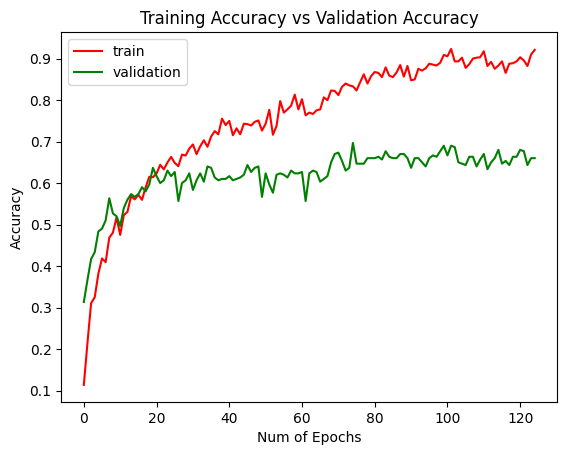

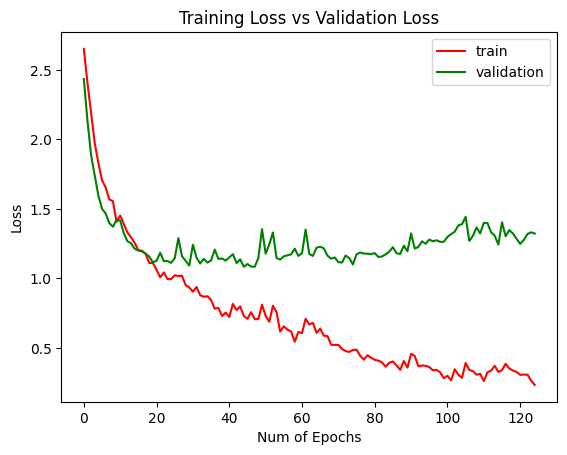

In [ ]:
plt.figure(0)
plt.plot(trains.history['accuracy'],'r')
plt.plot(trains.history['val_accuracy'],'g')
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(trains.history['loss'],'r')
plt.plot(trains.history['val_loss'],'g')
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

## Predictions on Test Data

In [ ]:
predictions = model.predict(X_test)

10/10 [==============================] - 0s 3ms/step


In [ ]:
predictions[0].shape

(15,)

In [ ]:
np.sum(predictions[0])

1.0

In [ ]:
df = pd.DataFrame()
df["predictions"] = np.argmax(predictions,axis=1)
df["actual labels"] = y_test

df

predictions  actual labels
0             11             11
1             13             13
2              4              4
3              8              4
4              4              4
..           ...            ...
295            9              9
296            9              7
297            2             13
298           11             11
299            8              8

[300 rows x 2 columns]

In [ ]:
model.save('genremodel.h5')

In [ ]:
pick1 = {
    'norma':scaler,
    'model':model,
    'lgn':lookup_genre_name
}
pickle.dump(pick1, open('model1.p', 'wb'))

In [ ]:
pickled_model = pickle.load(open('model1.p', 'rb'))
print(pickled_model)

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-03-23 19:23:28           64
variables.h5                                   2023-03-23 19:23:30      2285416
config.json                                    2023-03-23 19:23:28         2700
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19